## $$\text{CS378 Final Project: Fifa 2019 Players Analysis}$$
#### $$ \text{Safa Tinaztepe, Sam Larson, and Shayan Jiwani} $$
<hr>

### 1: Collaboration Statement
<hr>

THIS CODE IS MY OWN WORK, IT WAS WRITTEN WITHOUT CONSULTING

A TUTOR OR CODE WRITTEN BY OTHER STUDENTS - Safa Tinaztepe, Sam Larson, and Shayan Jiwani

### 2: Problem Description | Abstract
<hr>

We are using the Fifa 2019 player dataset we found on Kaggle that contains statistics of all current professional association football players registered with FIFA. The main goal of this project is to determine if a player plays defense, offense, midfield, or goalkeeper based on their numerical attributes.  We want to see if we can find a pattern in play style and skill-set amongst players with similar positions.  Initially we attempted this by classifying players by their role, but with 27 different target labels, we had low performing results.  We narrowed our problem to just classify players by their role on the field (offense: red, defense: blue, midfield: green, goalkeeper: purple) and yielded marginally better results.  In this paper we will present a number of different classification algorithms we used to achieve this goal and present the results of this endeavor.

<center><img src="positions.png" alt="https://i.imgur.com/5jmGa8P.png"/></center>

### 3: Data Description
<hr>

Our dataset consists of 18,147 player records each with 90 attributes. We decided to only look at numerical attributes to keep our data more statistical and mathematical rather than deal with ordinal and nominal information.  The dataset can be found here: https://www.kaggle.com/karangadiya/fifa19.  For our X data to feed into the classification algorithms, we focused on the following attributes whose values range from 0-100:

In [20]:
features = ['Skill Moves','Age','Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Offense', 'Defense']

Scores closer to 100 signify that player is highly proficient in that skill.  It is important to note that every player has a nonnull value in every attribute, even if that attribute does not correspond to the player’s given role.  For a full description of every attribute, visit https://www.fifauteam.com/fifa-19-attributes-guide/.

### 4: Data Pre-Processing
<hr>

In this section, we will describe some attributes and discuss how we reencoded them to better satisfy our programmatic needs.  We will also discuss how we cleaned our null values in the data, and a visualization technique to better grasp our problem.


Some attributes in the dataset are monetary, including Value, Wage, and Release Clause.  These columns are formatted as “€amt [K,M]” as a string, reading AMT thousand or million Euros as a string.  We processed these attributes by using regex to strip the € symbol and the K and M symbols and multiplying the number by a thousand or a million accordingly.  Thus we convert the string representation into a floating point range that we can use to train and test against for our regression algorithm.


Another attribute we had to process was the player position.  Before processing, players were divided into 27 positions, or classes.  We initially tried running classifiers on these labels which yielded remarkably low performance.  To combat this deficiency and to make our problem more relevant, we decided to encode these labels to the behaviors of these positions by creating a new attribute called “Role” that describes the activity on the field of the class.  Players positioned towards the opposing team’s goal were labeled “O” for Offense; players that facilitate front-field and backfield plays and spend their time around the midline of the field were labeled “M” for midfielder; players behind the midline on their own side were labeled “D” for defense; players whose job is to guard against shots on goal are “GK” for goalkeepers, in accordance to how soccer is pictured at a high level.  We used a LabelEncoder to transform these nominal strings into integer categories for our classifiers.


**Null Values**


There are 48 players with null entries for features we want to extract.  One way to deal with these is to replace these entries with 0 to denote the absence.  This is however an inadequate way to deal with these players as they would be significant outliers that would disturb classification.  We choose to drop these players entirely from consideration, as they are few compared to the data we do have.


**Visualization**


In order to visualize this pre-processing, we used principal component analysis (PCA) to visualize these classes of players and see any initially prominent patterns.  We originally we reduced the data to two columns, but much of the data overlapped and it was hard to see the clusters.  Instead we reduced the data to 3 components and plotted them on a 3d axis and got the results we intended to see.  We color coded offense as red, midfield as green, defense as blue, and goalkeeper as purple.  Significant clusters do appear meaning the data is separable by the data available and we validated that we will get meaningful results in classification.  This is presented in the feature importance and clustering section.


#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from eli5 import show_weights
from eli5.sklearn import PermutationImportance

/Users/safa/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Pre Processing

In [3]:
# encodes the workrate field 
def evaluate(label):
    if label == 'High':
        return 3
    elif label == 'Medium':
        return 2
    elif label == 'Low':
        return 1
    
classes = {
 "ST":"O", "CF":"O", "RF":"O", "LF":"O", "RW":"O","LW":"O","RS":"O","LS":"O",
 "CAM":"M","RM":"M", "CM":"M", "LM":"M","CDM":"M","RCM":"M","LCM":"M","LDM":"M","LAM":"M","RDM":"M","RAM":"M",
 "RWB":"D","RB":"D", "CB":"D", "LB":"D","LWB":"D","RCB":"D","LCB":"D",
 "GK":"GK"
}

In [4]:
df = pd.read_csv("data.csv")
df.drop(df[df['Work Rate'].isnull()].index, inplace=True)
df.drop(df[df['Position'].isnull()].index, inplace=True)
df['Offense'] = df["Work Rate"].map(lambda x: evaluate(x.split('/ ')[0]))
df['Defense'] = df["Work Rate"].map(lambda x: evaluate(x.split('/ ')[1]))
df.drop(df[df[features].isnull().any(axis=1)].index, inplace=True)
df.drop(df[['Unnamed: 0', 'ID']], axis=1, inplace=True)

# reecode target labels
df['Role'] = df.Position.replace(classes)

# isolate our X data for training and testing
X = df[features]

# isolate target labels
y = df['Role']

# new dataframe to discount midfielders
df2 = df[df.Role != 'M']
df2['Role'] = df2.Position.replace(classes)

/Users/safa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [5]:
def preproc_euros(df):
    check_cols = df.columns
    currency_cols = ['Value', 'Wage', 'Release Clause']
    df[check_cols] = df[check_cols].replace({'\€': ''}, regex=True)
    df[currency_cols] = df[currency_cols].apply(lambda x: x.str.strip('KM'))

    df[currency_cols] = df[currency_cols].apply(pd.to_numeric, errors='coerce')
    df['Value'] = df['Value'].mul(1000000, axis=0)
    df['Release Clause'] = df['Release Clause'].mul(1000000, axis=0)
    df['Wage'] = df['Wage'].mul(1000, axis=0)

    return df

df = preproc_euros(df)

Text(0.5,1,'Player Overall Rating vs. Monetary Value')

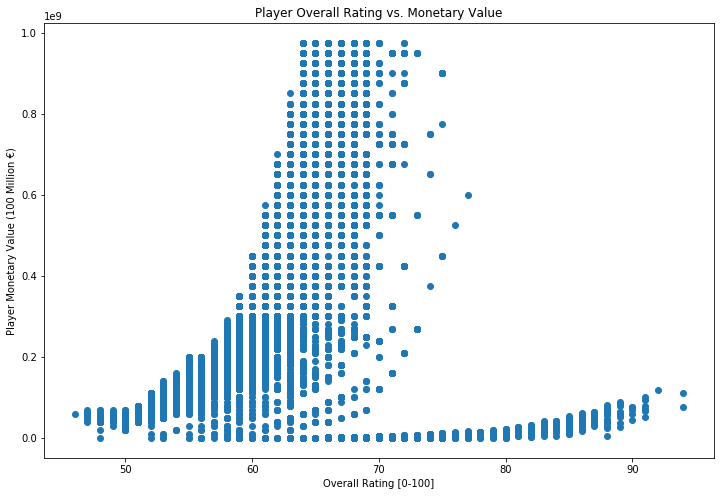

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(df.Overall, df.Value)
plt.xlabel("Overall Rating [0-100]")
plt.ylabel("Player Monetary Value (100 Million €)")
plt.title("Player Overall Rating vs. Monetary Value")

### 5: Data Mining
<hr>

We are essentially solving a data mining classification problem.  In this section, we will describe the many different classification algorithms we learned in class and how they work and will describe their effectiveness in the Results section.

**Decision Tree**: Decision Tree Classification consists of a flowchart methodology of choosing a prediction. Internal nodes represent a test on an attribute, each branch represents an outcome of the test, and all the leaf nodes are some class label. What happens is that we trace a path from the root node to some leaf node to predict a class label.

**Random Forest**: Random Forest is a popular ensemble method that consists of a collection of decision tree classifiers. These classifiers come together to form our ensemble method, hence “random forest.” Each of these tree classifiers depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest. We collect votes from each of these trees and take the majority as our collective vote. This algorithm is more robust to outliers and errors, however, we can offset this by having many trees.		

**Neural Network**: A neural network is a set of connected I/O units in which each connection has a weight associated with it. The neural net adjusts the weights during the learning phase to better guess the correct class label. The drawback to the great accuracy of neural nets is the time it spends in the learning phase and the required parameters that are better determined empirically. Another drawback is that it is difficult to understand a neural net because the meaning associated with the learned weights and hidden layers is not meaningful for humans. The plus side to all this is that our neural net is more resistant to noise and outliers, thus allowing us to have higher accuracy than other classification methods. 

**SVM**: The main idea of Support Vector Machine Classification is to use a nonlinear mapping to convert the original training data into a higher dimension. After this, the algorithm searches for the most optimal linear separating hyperplane. This is boundary that basically separates the tuples of one class from another. The support vectors, which are the most important tuples, are used to find this hyperplane. 

**Clustering**:

**k-nearest-neighbor (knn)**: K-nearest-neighbors is a popular algorithm used in pattern recognition. It works by looking at an unknown tuple and tries to find the k training tuples that are most similar to it. These training tuples are described with n attributes, thus each tuple is a point in an n-dimensional space. The distance method used is typically the Euclidean distance, or any appropriate distance measure. The problem with the kNN algorithm is that it assigns equal weight to all of the attributes, leading to potentially low accuracy due to noisy or irrelevant attributes. 


#### Classification

Now we present the results of our classification algorithms.  To read these charts, the left hand subplot presents the accuracy of predicting <strong>preprocessed</strong> classes.  The right hand subplot shows the accuracy of the classifier when predicting the <strong>postprocessed</strong> classes.  By showing both charts, we argue that predicting classes by behaviors instead of specific positions yields best accuracy.


CPU times: user 2min 53s, sys: 6.29 s, total: 3min
Wall time: 46.6 s


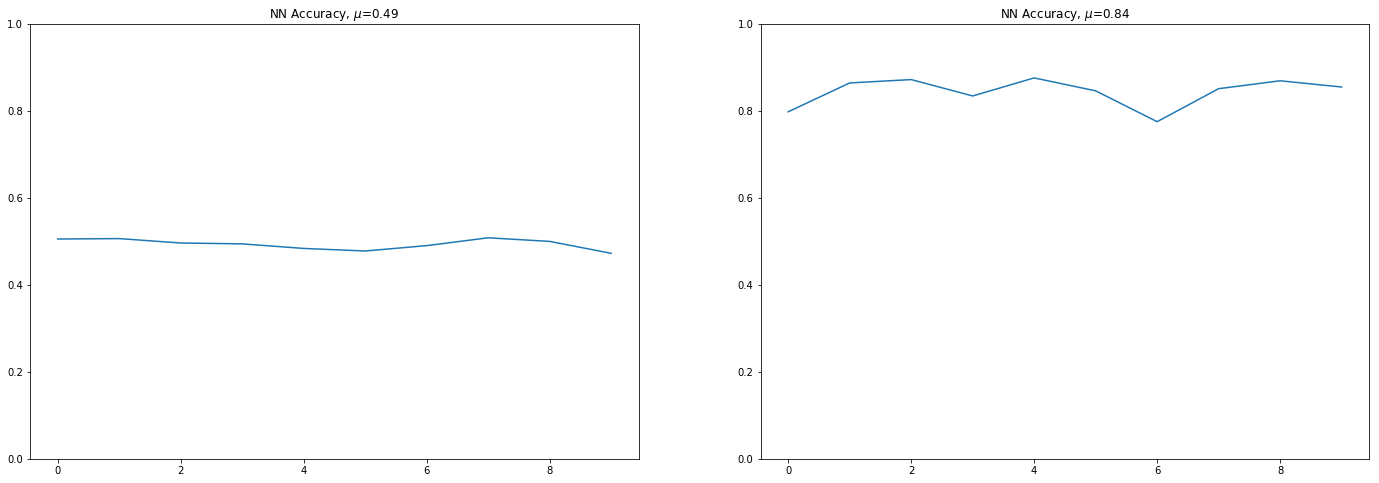

In [7]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8))
for ax,y in list(zip([ax1,ax2],[df.Position, df.Role])):
    scores = []
    for i in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        le = LabelEncoder()
        le.fit(y)
        nn = MLPClassifier()
        nn.fit(X_train, le.transform(y_train))
        y_pred = nn.predict(X_test)
        scores.append(sum(le.transform(y_test) == y_pred) / len(y_test))
    ax.set_title(f"NN Accuracy, $\mu$={round(np.mean(scores),2)}")
    ax.set_ylim([0,1])
    ax.plot(scores)

For the SVM model, we had to do an extra normalization method for the preprocessing step.  Without normalization, SVM had very poor accuracy.  When we applied normalization, SVM improved.

CPU times: user 4min 29s, sys: 2.51 s, total: 4min 32s
Wall time: 4min 22s


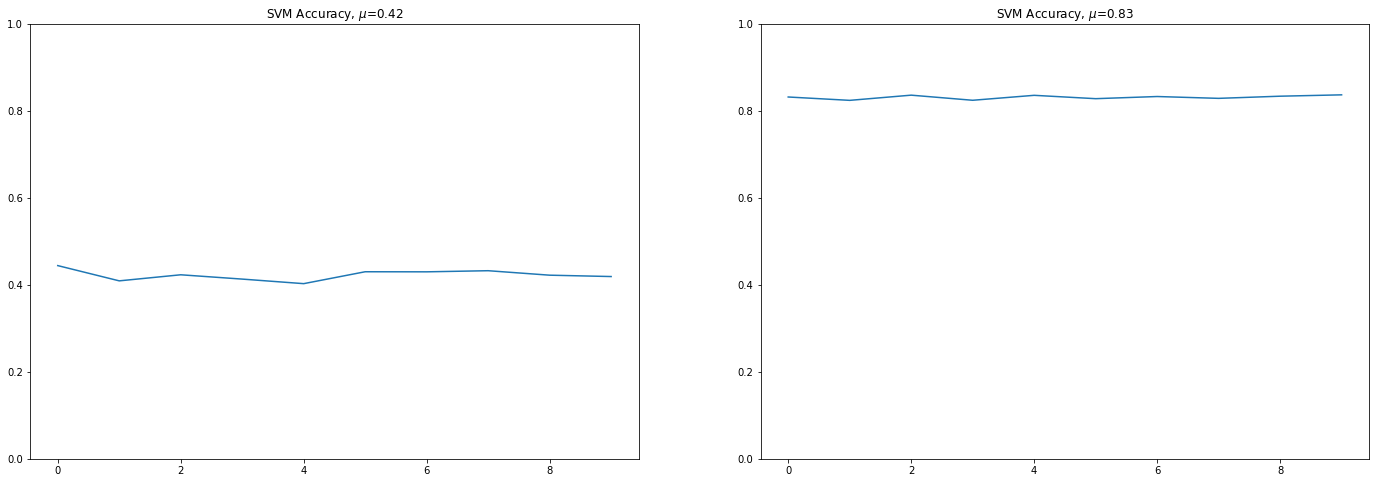

In [8]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8))
for ax,y in list(zip([ax1,ax2],[df.Position, df.Role])):
    scores = []
    for i in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        le = LabelEncoder()
        le.fit(y)
        svm = SVC()
        
        # svm requires the data to be normalized, so we apply that here
        svm.fit(normalize(X_train), le.transform(y_train))
        y_pred = svm.predict(normalize(X_test))
        scores.append(sum(le.transform(y_test) == y_pred) / len(y_test))
    ax.set_title(f"SVM Accuracy, $\mu$={round(np.mean(scores),2)}")
    ax.set_ylim([0,1])
    ax.plot(scores)

CPU times: user 7.17 s, sys: 160 ms, total: 7.33 s
Wall time: 7.33 s


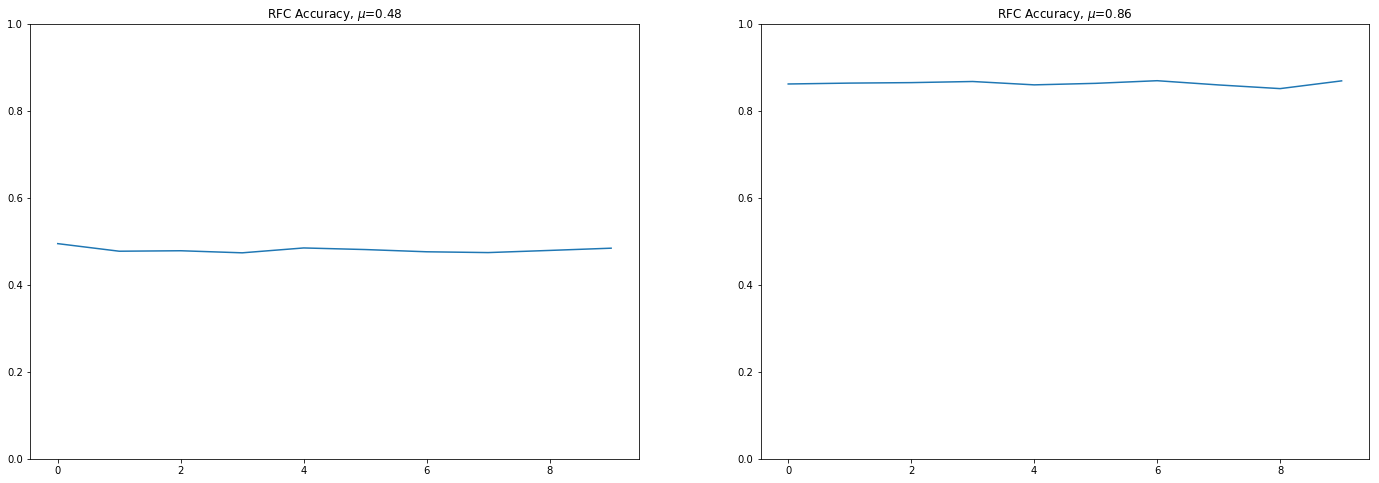

In [9]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8))
for ax,y in list(zip([ax1,ax2],[df.Position, df.Role])):
    scores = []
    for i in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        le = LabelEncoder()
        le.fit(y)
        rfc = RandomForestClassifier()
        rfc.fit(X_train, le.transform(y_train))
        y_pred = rfc.predict(X_test)
        scores.append(sum(le.transform(y_test) == y_pred) / len(y_test))
    ax.set_title(f"RFC Accuracy, $\mu$={round(np.mean(scores),2)}")
    ax.set_ylim([0,1])
    ax.plot(scores)

CPU times: user 57.6 s, sys: 130 ms, total: 57.7 s
Wall time: 57.8 s


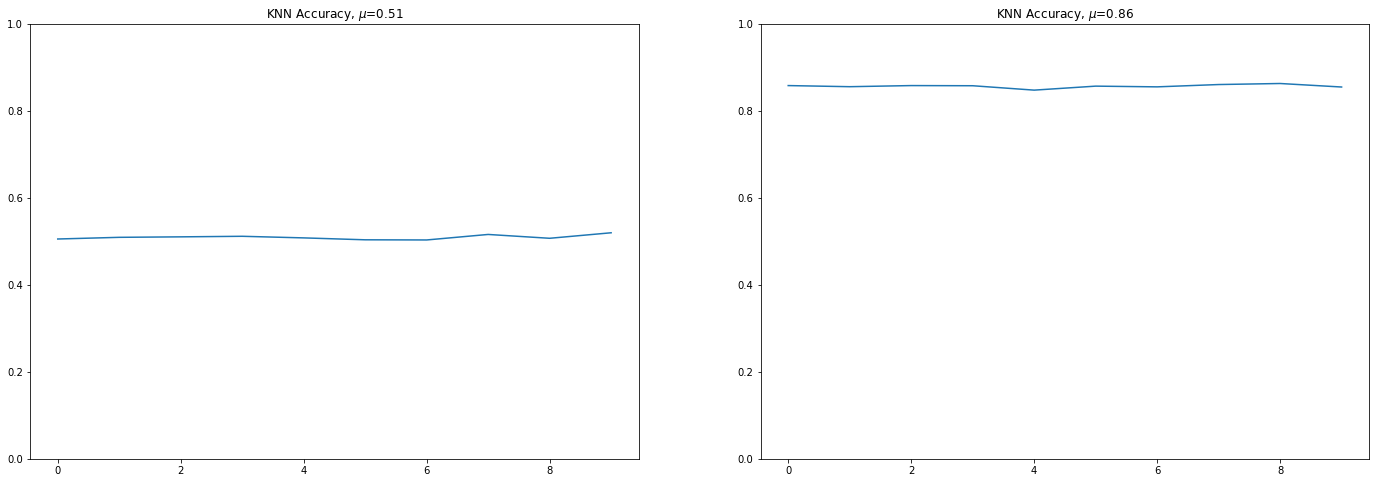

In [10]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8))
for ax,y in list(zip([ax1,ax2],[df.Position, df.Role])):
    scores = []
    for i in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        le = LabelEncoder()
        le.fit(y)
        knn = KNeighborsClassifier(len(set(y)))
        knn.fit(X_train, le.transform(y_train))
        y_pred = knn.predict(X_test)
        scores.append(sum(le.transform(y_test) == y_pred) / len(y_test))
    ax.set_title(f"KNN Accuracy, $\mu$={round(np.mean(scores),2)}")
    ax.set_ylim([0,1])
    ax.plot(scores)

CPU times: user 5.91 s, sys: 41.2 ms, total: 5.95 s
Wall time: 5.96 s


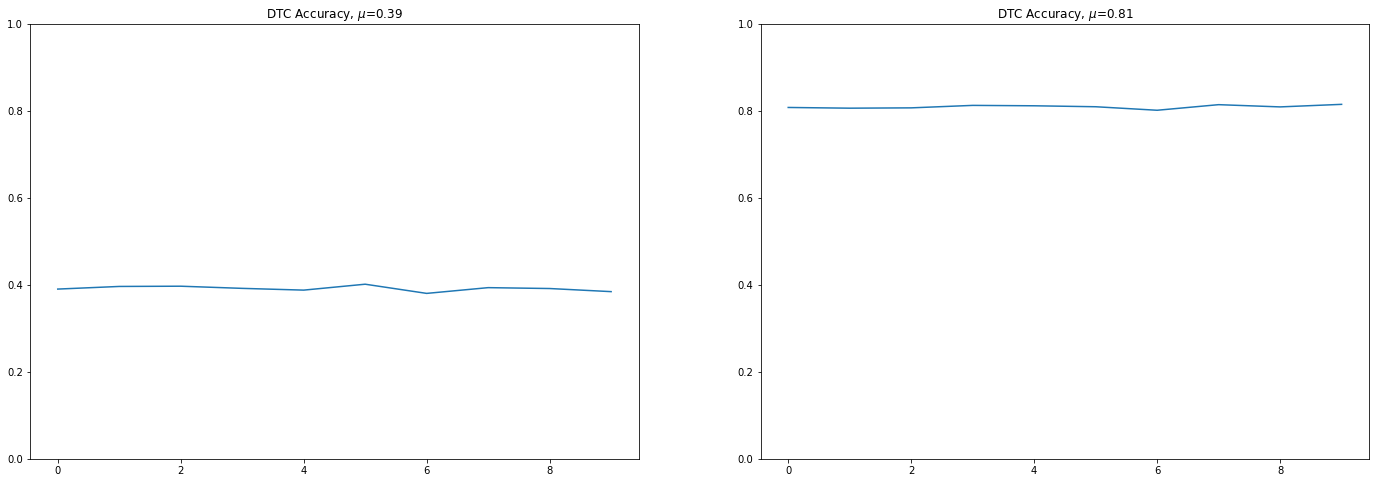

In [11]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8))
for ax,y in list(zip([ax1,ax2],[df.Position, df.Role])):
    scores = []
    for i in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        le = LabelEncoder()
        le.fit(y)
        dtc = DecisionTreeClassifier()
        dtc.fit(X_train, le.transform(y_train))
        y_pred = dtc.predict(X_test)
        scores.append(sum(le.transform(y_test) == y_pred) / len(y_test))
    ax.set_title(f"DTC Accuracy, $\mu$={round(np.mean(scores),2)}")
    ax.set_ylim([0,1])
    ax.plot(scores)


In [ ]:
# This block shows what the classifier predicted and compares it with the true values
y_pred = le.inverse_transform(y_pred)
for i in range(len(y_test)):
    if y_pred[i] == y_test.iloc[i]:
        print("Correct", y_pred[i])
    else:
        print("Predicted", y_pred[i], "Actual", y_test.iloc[i])

### Feature Importance and Clustering
-----

Permutation Importance attempts to isolate the impact each variable has by calculating the change in accuracy when that features is left out or changed.  A feature is important if permuting (removing/changing) its values increases the model error.  Thus, we can conclude that the model relied on this feature for prediction.  Feature is unimportant if changing its values does not affect the model accuracy.  These values can change per iteration however, 

In [13]:
# this cell calculates permutation importance using the multi-layer perceptron classifier as a basis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
dtc = MLPClassifier().fit(X_train, y_train)
perm = PermutationImportance(dtc).fit(X_test, y_test)
show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0960 ± 0.0039,SlidingTackle
0.0591 ± 0.0041,LongPassing
0.0571 ± 0.0047,Finishing
0.0457 ± 0.0069,Crossing
0.0404 ± 0.0072,ShortPassing
0.0328 ± 0.0029,Marking
0.0317 ± 0.0050,Vision
0.0298 ± 0.0038,BallControl
0.0236 ± 0.0043,Positioning
0.0216 ± 0.0021,Dribbling


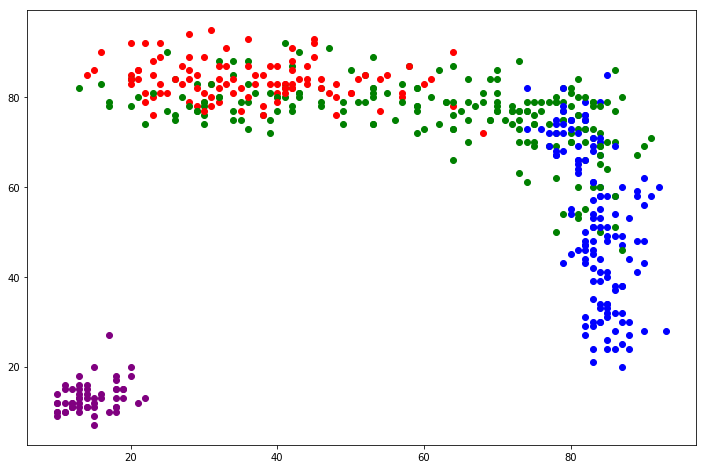

In [23]:
plt.figure(figsize=(12,8))
for i,row in df.iloc[:500].iterrows():
    if row.Role == 'O':
        color = 'red'
    elif row.Role == 'D':
        color = 'blue'
    elif row.Role == 'M':
        color = 'green'
    elif row.Role == 'GK':
        color = 'purple'
    plt.plot(row.StandingTackle,row.Positioning,c=color,marker='o')
plt.show()

With midfielders, the silhoutte score is:

In [15]:
silhouette_score(X[['StandingTackle','Finishing']], y)

0.2660845642089134

Without midfielders:

In [16]:
silhouette_score(X[y != 'M'][['StandingTackle','Finishing']], y[y!='M'])

0.6846222896575149

We can see that there are large overlapping regions when midfielders are included, obfuscating predictions by the classifiers.  Clusters become tight and separable with some outliers when midfields are omitted.  This explains the great increase in the silhoutte score.  A silhoutte score closer to 1 denotes tighter clusters that are far away from other clusters.

### Principal Component Analysis

PCA maps the 38 numerical features we use for the classifiers to 3 visible dimensions.  The axes in this graph are component scores.  Components are just mathematical abstractions combining all features, not an ordinal comparison.  We can see that midfielders are distributed across offense and defense clusters.  This is expected behavior but makes it difficult to classify.

By reducing the variables, we can visually identify player behaviors when labels are given or not given.


In [17]:
pca = PCA(n_components=3)
X_fit = pca.fit_transform(X)

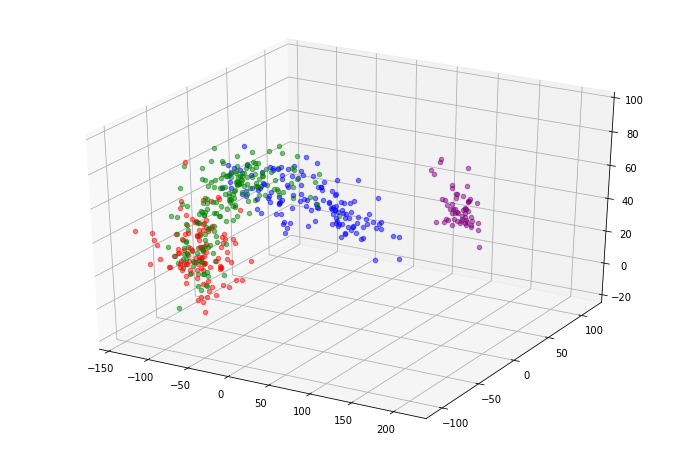

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# take the first 500 samples from the dataset to show that clusters form
# if we use all 18000 however, it might take longer to render and be more difficult to see
for i,row in df.iloc[:500].iterrows():
    if row.Role == 'O':
        color = 'red'
    elif row.Role == 'D':
        color = 'blue'
    elif row.Role == 'M':
        color = 'green'
    elif row.Role == 'GK':
        color = 'purple'
    
    ax.scatter(X_fit[i][0],X_fit[i][1],X_fit[i][2],c=color,marker='o', alpha=0.5)

In [ ]:
# this cell is only necessary if you want to visualize the clusters in 3d space
# by rotating around.  It is cool, but not crucial to the report

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
X_fit = pca.fit_transform(X)
def init():
    for i,row in df2.iloc[:500].iterrows():
        if row.Role == 'O':
            color = 'red'
        elif row.Role == 'D':
            color = 'blue'
        elif row.Role == 'GK':
            color = 'purple'
    #     if row.Role != X_pred[i]:
    #         color = 'black'

        ax.scatter(X_fit[i][0],X_fit[i][1],X_fit[i][2],c=color,marker='o', alpha=0.5)
    return fig,
def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i*4)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=50, blit=True)
ani.save('fig.mp4',writer='ffmpeg',fps=1000/50)

### 6: Results
<hr>

Below we present the results of our classification algorithms, their accuracies pre and post processing, and their execution times.  The NN had the highest overall accuracy.  The Random Forest Classifier had the best time-accuracy tradeoff.

<img src="table.jpg" alt="https://i.imgur.com/CLqBM5I.jpg"/>

#### Challenges:


As mentioned above in the description section, every player has a nonnull value in every attribute, even if that attribute does not correspond to the player’s given role.  Thus, outliers appear where players may have high skills in areas that their role typically does not consider important.  This was a major challenge in classification.  For example, a defensive player may have previously been trained as a striker, thus will have a higher Finishing attribute than other defensive players.  The classification algorithms have hard time distinguishing such a phenomenon.
Computing a linear regression model of a player’s wage and value also was a difficult challenge.  Some players are paid exorbitantly much compared to other players with similar skill stats (usually younger players).

### 6.1: Conclusions
<hr>

We found that offense, defense, and goalkeepers are highly distinguishable positions based on their stats. On the opposite end, we found that midfielders are indistinguishable from the offense and defense due to the necessary flexibility of their role, in addition to the many offensive-leaning and defensive-leaning subclasses that make up the midfielder class. 

Speaking on the most important factors of a player, some features such as SlidingTackle, Long Passing, and Finishing (scoring) are the biggest factors in determining the position of a player. For example, from our data we found that offensive players have high finishing and low tackling, defensive players have low finishing and high tackling. Goalkeepers are low in both stats, but are high in goalkeeping stats. Lastly, midfielders have sliding tackle and finishing values that range from high to low, making them a difficult class to predict.

### 7: Future Work
<hr>

One future problem we can try is seeing which side of the field a player’s role is based on what their preferred foot is. This would allow us to see how teams strategize and place they're different footed players.

We can also use different clustering algorithms, such as KMeans like we did in one of our homeworks.

Another test we can run is identifying the most overpaid players for their positions.  We can easily do this by finding the average numerical attribute per class and running a linear regression.  Then we identify the outliers using any outlier detection method and find the most overpaid/underpaid players.

### 7.1: Works Cited
<hr>

- Link to description of attributes
  - https://www.fifauteam.com/fifa-19-attributes-guide/
- Link to description of positions
  - https://www.fifauteam.com/fifa-ultimate-team-positions-and-tactics/
- Link to download the dataset
  - https://www.kaggle.com/karangadiya/fifa19
